## Entropic Estimation of Optimal Transport maps

Let $P$ be a source distribution and $Q$ be a target distribution such that $(T_0)_\sharp P = Q$, with $T_0$ being the optimal transport map between the two measures. 

This notebook demonstrates how to "learn" the entropic map on the basis of samples $X_1,\ldots,X_n \sim P$ and $Y_1,\ldots,Y_n \sim Q$ as demonstrated in the following paper [Pooladian and Niles-Weed (2021)](https://arxiv.org/abs/2109.12004) To do so, we first use the Sinkhorn solver provided in OTT, which returns optimal (entropic) dual potentials $(f_\varepsilon,g_\varepsilon)$. The paper defined the "Entropic map" as

$$ T_\varepsilon(x) = x - \nabla f_\varepsilon(x) = \mathbb{E}_{\pi_\varepsilon}[Y | X = x]\,. $$

This simply amounts to a barycentric projection of the entropic plan, conditional on the input. 


We will provide a complete tutorial of how to use this estimator using OTT, taking advantage of [ott.core.potentials.EntropicPotentials](../_autosummary/ott.core.potentials.EntropicPotentials.html)

In [1]:
%pip install ott-jax

from ott.core.sinkhorn import sinkhorn
from ott.geometry.pointcloud import PointCloud
from ott.core.potentials import EntropicPotentials

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time

from scipy import linalg
from scipy.linalg import sqrtm, inv, det
from math import *


### Example 1: Learning Gaussian to Gaussian transport maps

This first example exploits the closed-form solutions available for the Gaussian-to-Gaussian optimal transport problem (focusing on 2D distributions for ease of visualization). We begin by first drawing samples from two Gaussians, $P = \mathcal{N}(0,I)$ and $Q = \mathcal{N}(\mu,\Sigma)$ for some $\mu \in \mathbb{R}^d$ and $\Sigma \succ 0$.

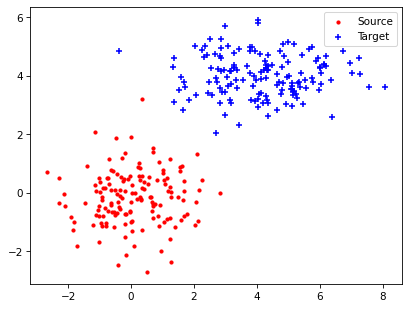

In [9]:
rng = jax.random.PRNGKey(0)

dim = 2
n = 2048

### data parameters
Sigma1 = jnp.eye(dim)
Sigma2 = jnp.array([[2,0],[0,0.5]])
mu1 = jnp.zeros((dim))
mu2 = jnp.ones((dim))*4

rng, *rngs = jax.random.split(rng, 5)
x = jax.random.multivariate_normal(rngs[0], mean=mu1, cov=Sigma1, shape=(n,))
y = jax.random.multivariate_normal(rngs[1], mean=mu2, cov=Sigma2, shape=(n,))

###we assume the points are sampled uniformly
a = jnp.ones((n,))
b = jnp.ones((n,))
a = a / jnp.sum(a)
b = b / jnp.sum(b)

fig = plt.figure(dpi=75)
plt.scatter(x[0:150,0],x[0:150,1],c='r',marker='.',label='Source')
plt.scatter(y[0:150,0],y[0:150,1],c='b',marker='+',label='Target')
plt.legend()

plt.show()

The aforementioned samples will be the basis of our estimator. From these samples, for a fixed regularization parameter $\varepsilon > 0$, we obtain $(\hat{f}_{n,\varepsilon},\hat{g}_{n,\varepsilon})$, and OTT will also output their gradient defined on all of $\mathbb{R}^d$. Beyond a visual comparison, in order to assess the performance of our estimator empirically, it is necessary to be able to compare to the optimal transport map (using mean-squared error as our criterion). 

It is known that for general Gaussian measures $P = \mathcal{N}(a,A)$ and $Q = \mathcal{N}(b,B)$, the true optimal transport map is known to be

$$ T_0(x) = A^{-1/2}(A^{1/2}BA^{1/2})^{1/2}A^{-1/2}(x-a) + b\,. $$

Thus, determining whether or not our estimator is close amounts to Monte Carlo integration with enough samples i.e.
$$ \| \hat{T}_{\varepsilon,n} - T_0\|^2_{L^2(P)} \simeq \frac{1}{N}\sum_{i=1}^N \| \hat{T}_{\varepsilon,n}(X_i) - T_0(X_i)\|^2_2\,, $$
where $X_i \sim P = \mathcal{N}(0,I)$.


To estimate the map using OTT, we call `entpots = EntropicPotentials()`, which takes in as inputs the potentials from the `sinkhorn()` method. To transport, we use `entpots.transport()` applied to new points that we want to pushforward according to our estimator.

Mean-Squared Error 0.078587934


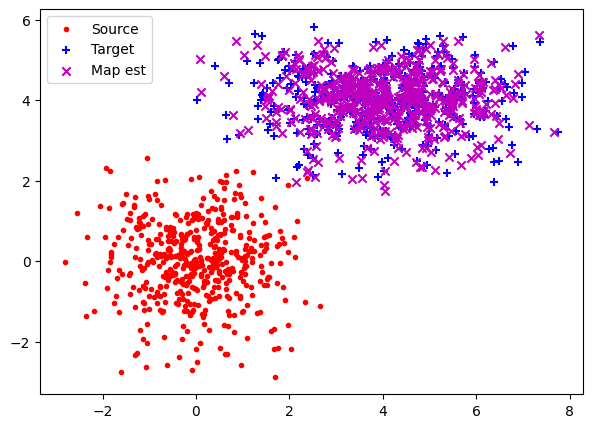

In [16]:
n_new = 10000
###newly sampled points from source distribution
x2 = jax.random.multivariate_normal(rngs[2], mean=mu1, cov=Sigma1, shape=(n_new,))

## Gaussian transport map
def g2g_transportmap(A,B):
    sqrtA, sqrtB = linalg.sqrtm( A ), linalg.sqrtm( B )
    InvsqrtA =  linalg.inv( sqrtA )
    transport_plan = InvsqrtA @ linalg.sqrtm( sqrtA @ B @ sqrtA ) @ InvsqrtA
    return transport_plan

###closed-form transport map on the newly sampled pointed
transportplan = g2g_transportmap(Sigma1,Sigma2)
y2 = (transportplan @ (x2.T)).T + mu2

###compute the estimated transport map with parameter "lbd" in two steps
varep = 10 ** (-1)
###step 1: return the output of sinkhorn on the given point clouds
out = sinkhorn(PointCloud(x, y, epsilon=varep),
                        a, b, threshold=0.005, lse_mode=True, jit=False,
                        max_iterations=1000)
entpots = EntropicPotentials(out.f, out.g, out.geom,a,b)
###step 2: return entpots.transport with newly sampled points
entmap = entpots.transport(x2)

print('Mean-Squared Error', np.mean(np.linalg.norm(entmap - y2,axis=1)) )

fig = plt.figure(figsize=(7,5))
plt.scatter(x2[0:500,0],x2[0:500,1],c='r',marker='.',label='Source')
plt.scatter(y2[0:500,0],y2[0:500,1],c='b',marker='+',label='Target')
plt.scatter(entmap[0:500,0],entmap[0:500,1],c='m',marker='x',label='Map est')
plt.legend()
plt.show()

### Example 2: Coordinate-wise transport maps

A second example is the case of coordinate-wise transport maps, where the underlying map is $T_0:\mathbb{R} \to \mathbb{R}$, and abusing notation, we write
$$ T_0(x) = (T_0(x_1),\ldots,T_0(x_d)), $$
for $x \in \mathbb{R}^d$.

A simple example is to consider the coordinate-wise exponential map, where the source distribution is uniform on $[-1,1]^d$, and the target density is then defined as  $Q = (T_0)_\sharp P$. We repeat the same experiment as above.

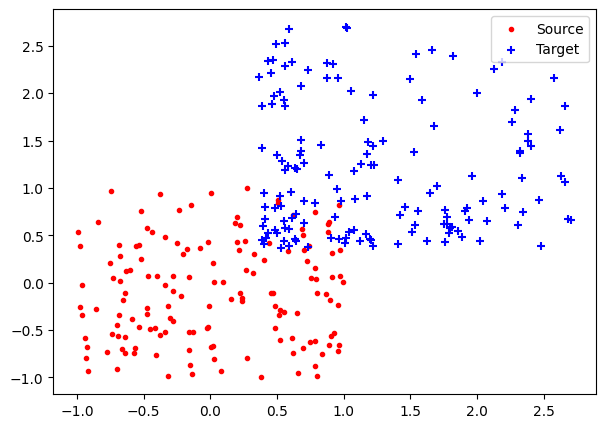

In [17]:
rng = jax.random.PRNGKey(0)

dim = 2
n = 2048

rng, *rngs = jax.random.split(rng, 5)
x = jax.random.uniform(rngs[0], shape=(n,dim))*2 - 1 ###uniform on [-1,1]^dim

###to get i.i.d samples from the "target", resample from the source, and perform the mapping
###if you don't resample, the target samples are not independent from the source samples
x_ = jax.random.uniform(rngs[1], shape=(n,dim))*2 - 1 
y = jnp.exp(x_)

###we assume the points are sampled uniformly
a = jnp.ones((n,))
b = jnp.ones((n,))
a = a / jnp.sum(a)
b = b / jnp.sum(b)

fig = plt.figure(figsize=(7,5))
plt.scatter(x[0:150,0],x[0:150,1],c='r',marker='.',label='Source')
plt.scatter(y[0:150,0],y[0:150,1],c='b',marker='+',label='Target')
plt.legend()
plt.show()

Mean-Squared Error 0.058662478


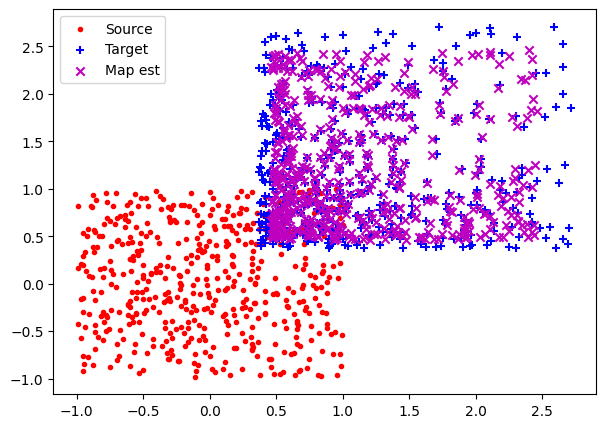

In [18]:
n_new = 10000
###newly sampled points from source distribution
x2 = jax.random.uniform(rngs[2], shape=(n,dim))*2 - 1 
###closed-form transport map on the newly sampled points
y2 = jnp.exp(x2)

###compute the estimated transport map with parameter "lbd" in two steps
lbd = 10 ** (-1)
###step 1: return the output of sinkhorn on the given point clouds
out = sinkhorn(PointCloud(x, y, epsilon=lbd),
                        a, b, threshold=0.005, lse_mode=True, jit=False,
                        max_iterations=1000)
entpots = EntropicPotentials(out.f, out.g, out.geom,a,b)
###step 2: return entpots.transport with newly sampled points
entmap = entpots.transport(x2)

print('Mean-Squared Error', np.mean(np.linalg.norm(entmap - y2,axis=1)) )

fig = plt.figure(figsize=(7,5))
plt.scatter(x2[0:500,0],x2[0:500,1],c='r',marker='.',label='Source')
plt.scatter(y2[0:500,0],y2[0:500,1],c='b',marker='+',label='Target')
plt.scatter(entmap[0:500,0],entmap[0:500,1],c='m',marker='x',label='Map est')
plt.legend()
plt.show()

### Estimation as a function of $\varepsilon$

Here we plot convergence of the estimator as a function of the regularization parameter $\varepsilon$ for a fixed number of samples $n$. What is the natural behavior? By the triangle inequality, we have that

$$ \|\hat{T}_{(\varepsilon , n)} - T_0\|^2_{L^2(P)} \lesssim \|\hat{T}_{(\varepsilon , n)} - T_\varepsilon \|^2_{L^2(P)} + \|T_0 - T_\varepsilon \|^2_{L^2(P)}\,.$$
 
The authors of [Pooladian and Niles-Weed (2021)](https://arxiv.org/abs/2109.12004) show that for fixed $n$, the first term grows as a function of $\varepsilon$, whereas the second term decreases in $\varepsilon$. Thus, we expect a natural "approximation error" vs "statistical error" tradeoff, which is illustrated in the next cell --- we see that there is an optimal choice for the regularization parameter that best estimates the optimal transport map, given that we only have finitely many samples.

In [19]:
rng = jax.random.PRNGKey(1)


dim = 5
lbds = 10 ** np.arange(-2.0, 0.0,step=0.1)
numtrials = 5
mse = np.zeros((numtrials,len(lbds)))
rng, *rngs = jax.random.split(rng, numtrials*3*len(lbds))
n = 4096 ### number of training samples from P and Q

for i,eps in enumerate(lbds):
    for k in range(numtrials):
        rng_iter = i+k
        x = jax.random.uniform(rngs[rng_iter], shape=(n,dim))*2 - 1 ###uniform on [-1,1]^dim

        ###to get i.i.d samples from the "target", resample from the source, and perform the mapping
        x_ = jax.random.uniform(rngs[rng_iter+len(lbds)], shape=(n,dim))*2 - 1 
        y = jnp.exp(x_)

        ###we assume the points are sampled uniformly
        a = jnp.ones((n,))
        b = jnp.ones((n,))
        a = a / jnp.sum(a)
        b = b / jnp.sum(b)

        ### monte-carlo samples
        n_new = 50000
        ###newly sampled points from source distribution
        x2 = jax.random.uniform(rngs[rng_iter+len(lbds)], shape=(n_new,dim))*2 - 1 
        ###closed-form transport map on the newly sampled points
        y2 = jnp.exp(x2)

        out = sinkhorn(PointCloud(x, y, epsilon=eps),
                        a, b, threshold=0.005, lse_mode=True, jit=False,
                        max_iterations=1000)
        entpots = EntropicPotentials(out.f, out.g, out.geom,a,b,)
        entmap = entpots.transport(x2)

        mse[k,i] = (jnp.linalg.norm( (y2 - entmap),axis=1)**2).mean()

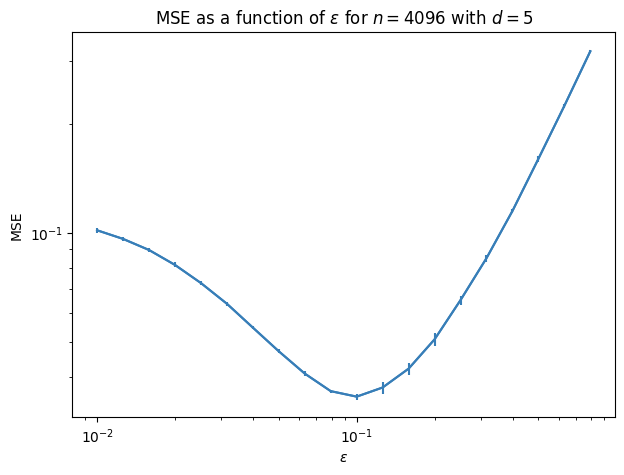

In [20]:
fig = plt.figure(figsize=(7, 5))
x = np.array(lbds)
###compute the means across the trials
y_means = np.mean(mse,axis=0)
###compute the standard deviation across trials
y_stds = np.std(mse,axis=0)
c1='#377eb8'
plt.loglog(x,y_means,label=r'$\hat{T}_\epsilon$',c=c1,linewidth=1.5)
plt.errorbar(x,y_means,yerr=y_stds,c=c1,linewidth=1.5)
plt.ylabel('MSE')
plt.xlabel(r'$\varepsilon$')
plt.title(r'MSE as a function of $\varepsilon$ for $n=${} with $d=${}' .format(n,dim))
plt.show()